Beal, L.D.R., Hill, D., Martin, R.A., and Hedengren, J. D., GEKKO Optimization Suite, Processes, Volume 6, Number 8, 2018, doi: 10.3390/pr6080106.

In [1]:
from gekko import GEKKO
import numpy as np
from numpy.random import seed
from numpy.random import randint
from math import sqrt
import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [2]:
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 50000', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 5000', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 5000', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 2', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.00005', \
                    # covergence tolerance
                    'minlp_gap_tol 0.0001']


In [3]:
# Input 1
xs = [3, 89, 72, -88, 73]
ys = [23, 95, 90, -47, 4]
rs = [2, 4, 1, 1, 4]


# Input 2
xs = [-84, 16, 80, -8, -93]
ys = [52, 10, -90, -99, 45]
rs = [1, 4, 2, 1, 3]


# Input 3
xs = [39, 49, -27, -23, -44]
ys = [-22, 16, -44, -30, -56]
rs = [3, 1, 2, 4, 1]

n = 5

In [4]:
# Integer constraints - Can be 0 (not connected) or 1 (connected)

tot = n*(n-1)

# Connected or not
c = []
for i in range(n):
    c.append([0] * n)
        
for i in range(n):
    for j in range(n):
        if (i != j) :       
            c[i][j] = m.Var(value=0, lb=0, ub=1, integer=True) 
        else:
            c[i][j] = 0      

# Real Value constraints - Center of Nodes 
# X-Coorindates
x = [m.Var(value=xs[i], lb=xs[i]-rs[i], ub=xs[i]+rs[i]) for i in range(n)]
# Y-Coorindates
y = [m.Var(value=ys[i], lb=ys[i]-rs[i], ub=ys[i]+rs[i]) for i in range(n)]


#print(x)
#print(y)
#print(c)



In [5]:
### Objective Function
objective_test = 0
indices_array = list(range(0, n))
#print(indices_array)
for i in range(n):    
    for j in range(n):
        dist = m.Intermediate((x[i] - x[j])*(x[i] - x[j]) + (y[i] - y[j])*(y[i] - y[j]))
        objective_test = objective_test + m.Intermediate(m.sqrt(dist)*c[i][j])
        
#print(objective_test)

### Constraint Equations/Inequations

# xij
# Node i can go to only one j (i != j)
for i in range(n):
    eq = 0
    for j in range(n):
        eq  = eq + c[i][j]
    m.Equation(eq == 1)

# xij
# Node j can go to only one i (j != i)
for i in range(n):
    eq = 0
    for j in range(n):
        eq  = eq + c[j][i]
    m.Equation(eq == 1)


# Neighborhood Constraint                   
for i in range(n):
    left_term = (x[i] - xs[i])*(x[i] - xs[i]) + (y[i] - ys[i])*(y[i] - ys[i])
    right_term = rs[i]*rs[i]                
    m.Equation(left_term <= right_term)
                   

In [6]:
def compare_if_lists_same(list1, list2):
    rows = len(list1)
    columns = len(list1[0])
    count = 0
    for i in range(rows):
        for j in range(columns):
            if list1[i][j] != list2[i][j]:
                count = count + 1
            else:
                count = count
    if count == 0:
        return(True)
    else:
        return(False)
                
            

In [7]:
def TRUST_TECH_x(x, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, ii_change, n):    
    i = 0
    x_new = x
    c = cost_prev
    tol = 1
    while (tol >= 0) & (i <= 20):
        x_new = x_new + step_size*direction        
        xv_copy[ii_change] = x_new
        
        cost_curr = compute_cost(xv_copy, yv_copy, cv_copy, n)
        #print(i)
        #print(cost_curr)
        tol = cost_curr - cost_prev
        cost_prev = cost_curr
        i = i + 1
    if (tol >= 0):
        x_new = x
        cost_curr = c
        
    return x_new, cost_curr
    

In [8]:
def TRUST_TECH_y(y, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, ii_change, n):    
    i = 0
    y_new = y
    c = cost_prev
    tol = 1
    while (tol >= 0) & (i <= 20):
        y_new = y_new + step_size*direction        
        yv_copy[ii_change] = y_new        
        cost_curr = compute_cost(xv_copy, yv_copy, cv_copy, n)
        tol = cost_curr - cost_prev
        cost_prev = cost_curr
        i = i + 1
    if (tol >= 0):
        y_new = y
        cost_curr = c        
    return y_new, cost_curr

In [9]:
import math

def compute_cost(xv_copy, yv_copy, cv_copy, n):
    cost_curr = 0
    for ii in range(n):
            for jj in range(n):
                dist = (xv_copy[ii] - xv_copy[jj])*(xv_copy[ii] - xv_copy[jj]) + (yv_copy[ii] - yv_copy[jj])*(yv_copy[ii] - yv_copy[jj])
                cost_curr = cost_curr + (math.sqrt(dist)*cv_copy[ii][jj])
    return cost_curr

In [10]:
# Solving
import time
n_components = n
cv_prev = []
for i in range(n):
    cv_prev.append([0] * n)
step_size = n/10.0
direction = 1
tol = 0.1
start_time = time.time()

while (n_components > 1):
    m.Obj(objective_test) # Objective
    m.solve(disp=True) # Solve
    
    # Reading Output Values from the Solver
    xv = [0] * n
    for i in range(n):
        xv[i] = x[i][0]

    yv = [0] * n
    for i in range(n):
        yv[i] = y[i][0]

    cv = []
    for i in range(n):
        cv.append([0] * n)
        
    for i in range(n):
        for j in range(n):
            if (i != j) :       
                cv[i][j] = c[i][j][0] 
            else:
                cv[i][j] = 0 
   
    result = compare_if_lists_same(cv_prev, cv)
    print(result)
    if result == False:
        # Checking Number of Connected Components in Graph
        graph = cv.copy()
        graph = csr_matrix(graph)

        n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
        print(n_components)
        if n_components > 1:

            # Creating a List of Connected Components
            connected_components_list = []
            label_range = list(range(n_components))
            for i in range(n_components):
                label_value = label_range[i]
                connected_components_list_element = []
                for j in range(n):
                    if label_value == labels[j]:
                        ele = j+1
                        connected_components_list_element.append(ele)
                connected_components_list.append(connected_components_list_element)
            
            # Add Constraints
            for i in range(n_components):
                connected_components_list_element = connected_components_list[i]
                len_conn = len(connected_components_list_element)
                right_term = len_conn - 1
                left_term = 0
                if len_conn == 2:
                    ele1 = connected_components_list_element[0] - 1  
                    ele2 = connected_components_list_element[1] - 1  
                    left_term = left_term + c[ele1][ele2] + c[ele2][ele1]
                else:
                    for j in range(0, len_conn):                          
                        ele1 = connected_components_list_element[j] - 1  
                        for k in range(n):
                            if cv[ele1][k] == 1:
                                ele2 = k 
                        left_term = left_term + c[ele1][ele2] 
                     
                m.Equation(left_term <= right_term)
                
                
            # TRUST-TECH
            
            xv_copy = xv.copy()
            yv_copy = yv.copy()
            cv_copy = cv.copy() 
            cost_prev = compute_cost(xv_copy, yv_copy, cv_copy, n)   
            found = 0
            i_loop = 0
            x_new_array = []
            x_new_or_not = []
            cost_array_x = []
            y_new_array = []
            y_new_or_not = []
            cost_array_y = []
            for i_loop in range(n):                
                x_check = x[i_loop][0]
                y_check = y[i_loop][0]
                x_new, cost_new_x = TRUST_TECH_x(x_check, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, i_loop, n)
                y_new, cost_new_y = TRUST_TECH_y(y_check, step_size, direction, xv_copy, yv_copy, cv_copy, cost_prev, i_loop, n)
                if x_new != x_check:
                    x_new_or_not.append(1)
                else:
                    x_new_or_not.append(0)
                if y_new != y_check:
                    y_new_or_not.append(1)
                else:
                    y_new_or_not.append(0)
                x_new_array.append(x_new)
                y_new_array.append(y_new)
                cost_array_x.append(cost_new_x)
                cost_array_y.append(cost_new_y)
                
            for i in range(n):
                if x_new_or_not[i] == 1:
                    x[i][0] = x_new_array[i]
                    
            for i in range(n):
                if y_new_or_not[i] == 1:
                    y[i][0] = y_new_array[i]

                    

    else:
        print('Solution is Stuck')
        n_components = 1
        
                     
    cv_prev = cv.copy()
print("--- %s seconds ---" % (time.time() - start_time))

apm 104.167.146.65_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           35
   Intermediates:           50
   Connections  :            0
   Equations    :           66
   Residuals    :           16
 
 Number of state variables:             35
 Number of total equations: -           15
 Number of slack variables: -            5
 ---------------------------------------
 Degrees of freedom       :             15
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.01 NLPi:   13 Dpth:    0 Lvs:    3 Obj:  1.28E+02 Gap:       NaN
--Integer Solution:   1.28E+02 Lowest

In [11]:
print('Results')
print(x)
print(y)
for i in range(n):
    print(c[i])

print('Objective: ' + str(m.options.objfcnval))

Results
[[36.804365059], [48.40327712], [-26.120886799], [-20.440308011], [-43.200452885]]
[[-19.95569362], [15.197552108], [-45.796431736], [-33.073757687], [-55.39939503]]
[0, [1.0], [0.0], [0.0], [0.0]]
[[0.0], 0, [0.0], [1.0], [0.0]]
[[1.0], [0.0], 0, [0.0], [0.0]]
[[0.0], [0.0], [0.0], 0, [1.0]]
[[0.0], [0.0], [1.0], [0.0], 0]
Objective: 721.79567519


In [12]:
# Reading Output Values from the Solver for Plotting
import networkx as nx

xv = [0] * n
for i in range(n):
    xv[i] = x[i][0]

yv = [0] * n
for i in range(n): 
    yv[i] = y[i][0]

cv = []
for i in range(n):
    cv.append([0] * n)
for i in range(n):
    for j in range(n):
        if (i != j) :       
            cv[i][j] = c[i][j][0] 
        else:
            cv[i][j] = 0 
            
graph_xs = []
graph_ys = []  
graph = cv.copy()
A = np.array(graph)

pos_dict = {}
nodess = range(0, n)
keyss = xv.copy()
valuess = yv.copy()


a = []
for i in range (n):
    a.append((keyss[i], valuess[i]))
a = tuple(a)  


pos_dict = dict(zip(nodess, a))
print(pos_dict)
H = nx.from_numpy_matrix(A)



{0: (36.804365059, -19.95569362), 1: (48.40327712, 15.197552108), 2: (-26.120886799, -45.796431736), 3: (-20.440308011, -33.073757687), 4: (-43.200452885, -55.39939503)}


C:\Users\Samhita\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


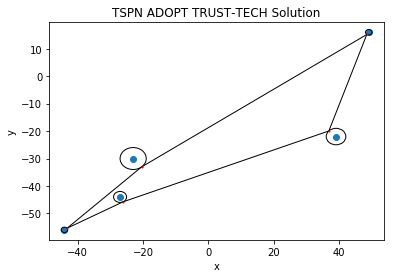

In [13]:

plt.scatter(xs, ys)
circles = []
for i in range(n):
    circle_i = plt.Circle((xs[i], ys[i]), rs[i], fill=False)
    circles.append(circle_i)
plt.title('TSPN ADOPT TRUST-TECH Solution')


# fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
fig = plt.gcf()
ax = fig.gca()

for i in range(n):    
    ax.add_artist(circles[i])
    
nx.draw(H, pos_dict, ax, node_size=1)
plt.xlabel('x')
plt.ylabel('y')
limits = plt.axis('on')
plt.draw()

fig.savefig('plotcircles_functions_5Nodes_TT_BB3.png')